In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from functions import util
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('./hopsworks_API.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [3]:
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1171609
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [5]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25']).join(weather_fg.select_all(), on=['city']) # 将pm25特征加入weather_fg生成新特征组
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.70s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,157.0,2014-01-01 00:00:00+00:00,12.381081,0.0,6.130579,110.833450,Meizhou
1,170.0,2014-01-02 00:00:00+00:00,15.585250,0.0,6.193674,124.484024,Meizhou
2,169.0,2014-01-03 00:00:00+00:00,15.187329,0.0,10.002560,336.879120,Meizhou
3,168.0,2014-01-04 00:00:00+00:00,11.337335,0.0,12.371645,353.517029,Meizhou
4,172.0,2014-01-05 00:00:00+00:00,11.814416,0.0,8.209263,94.712585,Meizhou
5,194.0,2014-01-06 00:00:00+00:00,13.312335,0.0,9.449572,110.497421,Meizhou
6,167.0,2014-01-07 00:00:00+00:00,16.772749,0.4,10.137691,174.696701,Meizhou
7,155.0,2014-01-08 00:00:00+00:00,12.503999,1.2,16.595179,349.205231,Meizhou
8,107.0,2014-01-09 00:00:00+00:00,11.701917,0.1,9.346143,12.299344,Meizhou
9,137.0,2014-01-10 00:00:00+00:00,11.639417,0.0,6.409617,59.524239,Meizhou


In [6]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

In [7]:
start_date_test_data = "2022-10-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    #test_start=test_start
    test_size=0.2
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 


In [9]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2014-01-01 00:00:00+00:00,12.381081,0.0,6.130579,110.833450,Meizhou
1,2014-01-02 00:00:00+00:00,15.585250,0.0,6.193674,124.484024,Meizhou
2,2014-01-03 00:00:00+00:00,15.187329,0.0,10.002560,336.879120,Meizhou
3,2014-01-04 00:00:00+00:00,11.337335,0.0,12.371645,353.517029,Meizhou
4,2014-01-05 00:00:00+00:00,11.814416,0.0,8.209263,94.712585,Meizhou
...,...,...,...,...,...,...
3937,2024-11-12 00:00:00+00:00,25.458998,0.0,10.182337,38.583073,Meizhou
3938,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou
3939,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou
3940,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou


In [10]:
X_test

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
10,2014-01-11 00:00:00+00:00,13.028999,0.1,6.409617,85.192108,Meizhou
16,2014-01-17 00:00:00+00:00,11.876918,0.0,11.542478,350.503601,Meizhou
21,2014-01-22 00:00:00+00:00,9.012334,0.0,8.759178,21.765890,Meizhou
22,2014-01-23 00:00:00+00:00,10.212334,0.0,8.788720,121.514008,Meizhou
27,2014-01-28 00:00:00+00:00,17.195665,0.0,8.049845,142.678894,Meizhou
...,...,...,...,...,...,...
3887,2024-09-23 00:00:00+00:00,23.117332,9.7,12.849528,338.198517,Meizhou
3902,2024-10-08 00:00:00+00:00,24.011084,1.5,10.538843,2.533964,Meizhou
3905,2024-10-11 00:00:00+00:00,24.244415,0.2,9.659814,41.238430,Meizhou
3906,2024-10-12 00:00:00+00:00,24.440247,0.0,9.037721,33.125301,Meizhou


In [11]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [12]:
y_train

,pm25
0,157.0
1,170.0
2,169.0
3,168.0
4,172.0
...,...
3937,71.0
3938,54.0
3939,54.0
3940,76.0


In [13]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 867.72534
R squared: 0.24463507765239212


In [15]:
df = y_test
df['predicted_pm25'] = y_pred

In [16]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
10,149.0,122.342606,2014-01-11 00:00:00+00:00
16,147.0,108.295052,2014-01-17 00:00:00+00:00
21,131.0,102.320877,2014-01-22 00:00:00+00:00
22,143.0,140.487213,2014-01-23 00:00:00+00:00
27,166.0,108.655655,2014-01-28 00:00:00+00:00


In [17]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

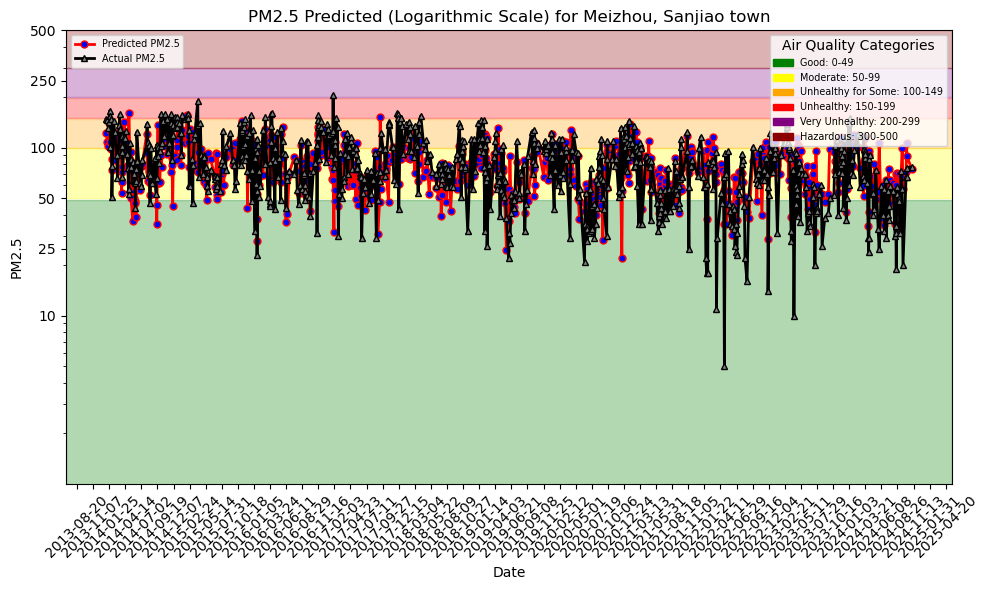

In [18]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

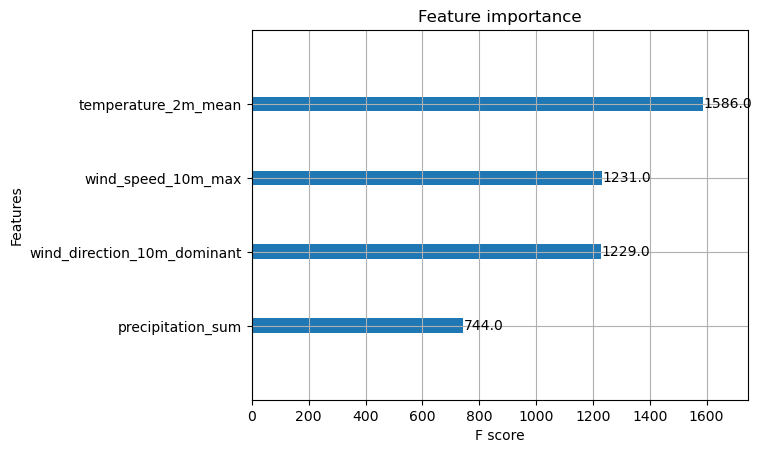

In [19]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)  # plot重要性，可设置重要性指标
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [20]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [21]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [22]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
}

In [23]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/541452 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/542840 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19695 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17322 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/151304 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/70372 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/121 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/682 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1171609/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)